<a href="https://colab.research.google.com/github/MudSnail/Land_Cover_Classification/blob/main/Model_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Increase RAM size 
a = []
while(1):
  a.append('1')

In [1]:
#Mount to Drive
from google.colab import drive
drive.mount('/content/drive')

#Import Pandas and Numpy
import pandas as pd
import numpy as np

#Import Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#misc
import copy
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


# Read in Data

In [2]:
#Load Data
data = pd.read_csv('/content/drive/MyDrive/james_bay_data.csv')
data.head()

,B01,B06,B11,B07,B05,B03,B09,B12,B8A,B04,B08,B02,Class
0,0.0055,0.0017,0.0009,0.0016,0.0026,0.0056,0.0001,0.0009,0.0003,0.0032,0.0012,0.0114,0
1,0.0054,0.0020,0.0009,0.0017,0.0021,0.0060,0.0001,0.0005,0.0007,0.0028,0.0014,0.0115,0
2,0.0058,0.0018,0.0007,0.0016,0.0028,0.0060,0.0001,0.0008,0.0007,0.0030,0.0012,0.0124,0
3,0.0057,0.0016,0.0007,0.0016,0.0023,0.0058,0.0001,0.0012,0.0006,0.0031,0.0011,0.0119,0
4,0.0066,0.0013,0.0008,0.0020,0.0029,0.0059,0.0001,0.0008,0.0005,0.0030,0.0014,0.0115,0


In [3]:
#Check value counts
data.Class.value_counts()

1     582967
8     508063
18    260790
2     134079
12    113461
10     67576
5      54330
16     32239
13     13597
14      1986
0        773
6        591
17       512
11       286
Name: Class, dtype: int64

In [4]:
#Remove rows with classes < 15000 data points
values = [0,6,11,13,14,17]
data = data[data.Class.isin(values) == False]

#Check value counts
data.Class.value_counts()

1     582967
8     508063
18    260790
2     134079
12    113461
10     67576
5      54330
16     32239
Name: Class, dtype: int64

# Create Subsample of Data And Feature Engineering

In [5]:
#SubSample ~100 000 for each class
sample = data.groupby('Class').apply(lambda x: x.sample(n=30000)).reset_index(drop=True)
sample.head(4)

,B01,B06,B11,B07,B05,B03,B09,B12,B8A,B04,B08,B02,Class
0,0.0125,0.1705,0.1521,0.1873,0.1034,0.0444,0.2001,0.0838,0.2044,0.0457,0.1998,0.0304,1
1,0.0052,0.1402,0.1134,0.1616,0.0693,0.0331,0.1754,0.0609,0.1791,0.0264,0.1746,0.0179,1
2,0.0079,0.1329,0.1082,0.1513,0.0728,0.0351,0.1646,0.0580,0.1717,0.0316,0.1663,0.0216,1
3,0.0050,0.1187,0.0897,0.1362,0.0563,0.0276,0.1531,0.0449,0.1502,0.0195,0.1441,0.0159,1


In [6]:
#Create NDVI column (B08-B04)/(B08+B04)
sample['NDVI'] = (sample.B08-sample.B04)/(sample.B08+sample.B04)
#Create Moisture index (B8A-B11)/(B8A+B11)
sample['Moisture'] = (sample.B8A-sample.B11)/(sample.B8A+sample.B11)
#Create NDWI (B3-B8)/(B3+B8)
sample['NDWI'] = (sample.B03-sample.B08)/(sample.B03+sample.B08)
#create NDSI (B3-B11)/(B3+B11)
sample['NDSI'] = (sample.B03-sample.B11)/(sample.B03+sample.B11)

In [7]:
#View new dataframe
sample.head()

,B01,B06,B11,B07,B05,B03,B09,B12,B8A,B04,B08,B02,Class,NDVI,Moisture,NDWI,NDSI
0,0.0125,0.1705,0.1521,0.1873,0.1034,0.0444,0.2001,0.0838,0.2044,0.0457,0.1998,0.0304,1,0.627699,0.146704,-0.636364,-0.548092
1,0.0052,0.1402,0.1134,0.1616,0.0693,0.0331,0.1754,0.0609,0.1791,0.0264,0.1746,0.0179,1,0.737313,0.224615,-0.681271,-0.548123
2,0.0079,0.1329,0.1082,0.1513,0.0728,0.0351,0.1646,0.0580,0.1717,0.0316,0.1663,0.0216,1,0.680647,0.226867,-0.651440,-0.510119
3,0.0050,0.1187,0.0897,0.1362,0.0563,0.0276,0.1531,0.0449,0.1502,0.0195,0.1441,0.0159,1,0.761614,0.252188,-0.678509,-0.529412
4,0.0092,0.1751,0.1385,0.1979,0.1001,0.0490,0.2233,0.0721,0.2284,0.0400,0.2191,0.0230,1,0.691239,0.245026,-0.634465,-0.477333


In [8]:
#Replace infinity values with Nan
sample.replace([np.inf, -np.inf], np.nan, inplace=True)

#Fill in infinity values
sample.fillna(999, inplace=True)

# Random Forest Model

In [9]:
#Split the Sampled DataData
y = sample['Class']
X = sample.drop(['Class'], axis = 1)

In [10]:
#Print data shapes
print(X.shape)
print(y.shape)

(240000, 16)
(240000,)


In [11]:
#Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    stratify = y, 
                                                    random_state=42)

In [12]:
#Instantiate Random Forest
rfc = RandomForestClassifier(random_state=42)

#Fit training data
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
#Predict X_test
y_prediction = rfc.predict(X_test)

#Print measure scores
print(f"Accuracy: {accuracy_score(y_test, y_prediction)}")
print(f"F1 Score: {f1_score(y_test, y_prediction, average='micro')}")
print(f"Precision Score: {precision_score(y_test, y_prediction, average='micro')}")
print(f"Recall Score: {recall_score(y_test, y_prediction, average='micro')}")
print(f"ROC AUC Score: {roc_auc_score(y_test, rfc.predict_proba(X_test),multi_class='ovr', average='macro')}")

#print full classification report
print(classification_report(y_test, y_prediction))

Accuracy: 0.6009722222222222
F1 Score: 0.6009722222222222
Precision Score: 0.6009722222222222
Recall Score: 0.6009722222222222
ROC AUC Score: 0.8992918068783069
              precision    recall  f1-score   support

           1       0.56      0.55      0.55      9000
           2       0.52      0.64      0.57      9000
           5       0.77      0.78      0.77      9000
           8       0.42      0.36      0.39      9000
          10       0.60      0.61      0.60      9000
          12       0.42      0.38      0.40      9000
          16       0.62      0.59      0.60      9000
          18       0.87      0.90      0.89      9000

    accuracy                           0.60     72000
   macro avg       0.60      0.60      0.60     72000
weighted avg       0.60      0.60      0.60     72000



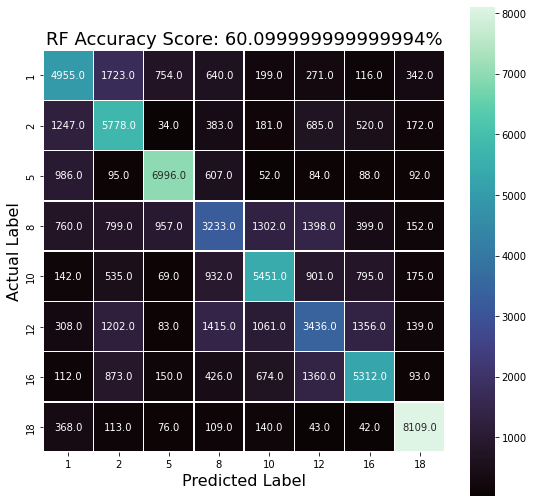

In [14]:
#Create a confusion matrix
matrix = confusion_matrix(y_test, y_prediction)

#Visualize the matrix with Seaborn

#Write title to display accuracy score
score = accuracy_score(y_test, y_prediction)
all_sample_title = 'RF Accuracy Score: {0}%'.format(round(score,3)*100)

#Set figure shape
plt.figure(figsize=(9,9))

#Use heatmap
p = sns.heatmap(matrix, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap="mako")

#Label the plot
label = [1,2,5,8,10,12,16,18]
p.set_ylabel('Actual Label', size=16)
p.set_xlabel('Predicted Label', size = 16)
p.set_xticklabels(label)
p.set_yticklabels(label)
p.set_title(all_sample_title, size = 18)

#save
fig = p.get_figure()
fig.savefig('/content/drive/MyDrive/james_bay_Cmatrix.png')

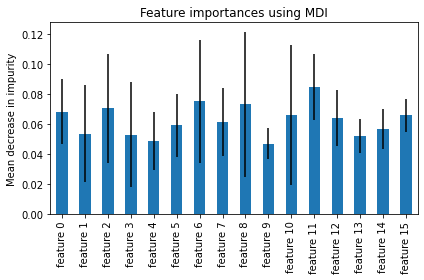

In [15]:
#Find which features were most important
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
feature_names = [f"feature {i}" for i in range(X.shape[1])]

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Random Forest Without Engineered Features

In [17]:
#Drop engineered features
sample = sample.drop(['NDVI', 'Moisture', 'NDWI', 'NDSI'], axis = 1)

#View dataframe
sample.head()

,B01,B06,B11,B07,B05,B03,B09,B12,B8A,B04,B08,B02,Class
0,0.0125,0.1705,0.1521,0.1873,0.1034,0.0444,0.2001,0.0838,0.2044,0.0457,0.1998,0.0304,1
1,0.0052,0.1402,0.1134,0.1616,0.0693,0.0331,0.1754,0.0609,0.1791,0.0264,0.1746,0.0179,1
2,0.0079,0.1329,0.1082,0.1513,0.0728,0.0351,0.1646,0.0580,0.1717,0.0316,0.1663,0.0216,1
3,0.0050,0.1187,0.0897,0.1362,0.0563,0.0276,0.1531,0.0449,0.1502,0.0195,0.1441,0.0159,1
4,0.0092,0.1751,0.1385,0.1979,0.1001,0.0490,0.2233,0.0721,0.2284,0.0400,0.2191,0.0230,1


In [19]:
#Split the Sampled DataData
y2 = sample['Class']
X2 = sample.drop(['Class'], axis = 1)

#Split into training and test data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, 
                                                    test_size = 0.3, 
                                                    stratify = y2, 
                                                    random_state=42)

In [20]:
#Instantiate Random Forest
rfc_2 = RandomForestClassifier(random_state=42)

#Fit training data
rfc_2.fit(X_train2, y_train2)

RandomForestClassifier(random_state=42)

In [21]:
#Predict X_test
y_prediction2 = rfc_2.predict(X_test2)

#Print measure scores
print(f"Accuracy: {accuracy_score(y_test2, y_prediction2)}")
print(f"F1 Score: {f1_score(y_test2, y_prediction2, average='micro')}")
print(f"Precision Score: {precision_score(y_test2, y_prediction2, average='micro')}")
print(f"Recall Score: {recall_score(y_test2, y_prediction2, average='micro')}")
print(f"ROC AUC Score: {roc_auc_score(y_test2, rfc_2.predict_proba(X_test2),multi_class='ovr', average='macro')}")

#print full classification report
print(classification_report(y_test2, y_prediction2))

Accuracy: 0.6028611111111111
F1 Score: 0.6028611111111111
Precision Score: 0.6028611111111111
Recall Score: 0.6028611111111111
ROC AUC Score: 0.9001425040784832
              precision    recall  f1-score   support

           1       0.55      0.55      0.55      9000
           2       0.53      0.65      0.58      9000
           5       0.77      0.78      0.77      9000
           8       0.42      0.36      0.39      9000
          10       0.61      0.61      0.61      9000
          12       0.42      0.38      0.40      9000
          16       0.62      0.59      0.60      9000
          18       0.88      0.90      0.89      9000

    accuracy                           0.60     72000
   macro avg       0.60      0.60      0.60     72000
weighted avg       0.60      0.60      0.60     72000



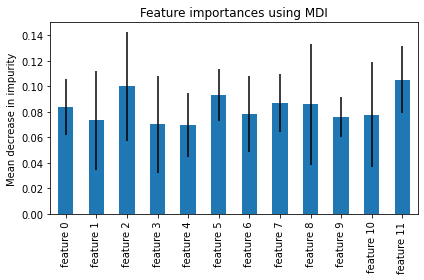

In [22]:
#Find which features were most important
importances = rfc_2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_2.estimators_], axis=0)
feature_names = [f"feature {i}" for i in range(X2.shape[1])]

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()